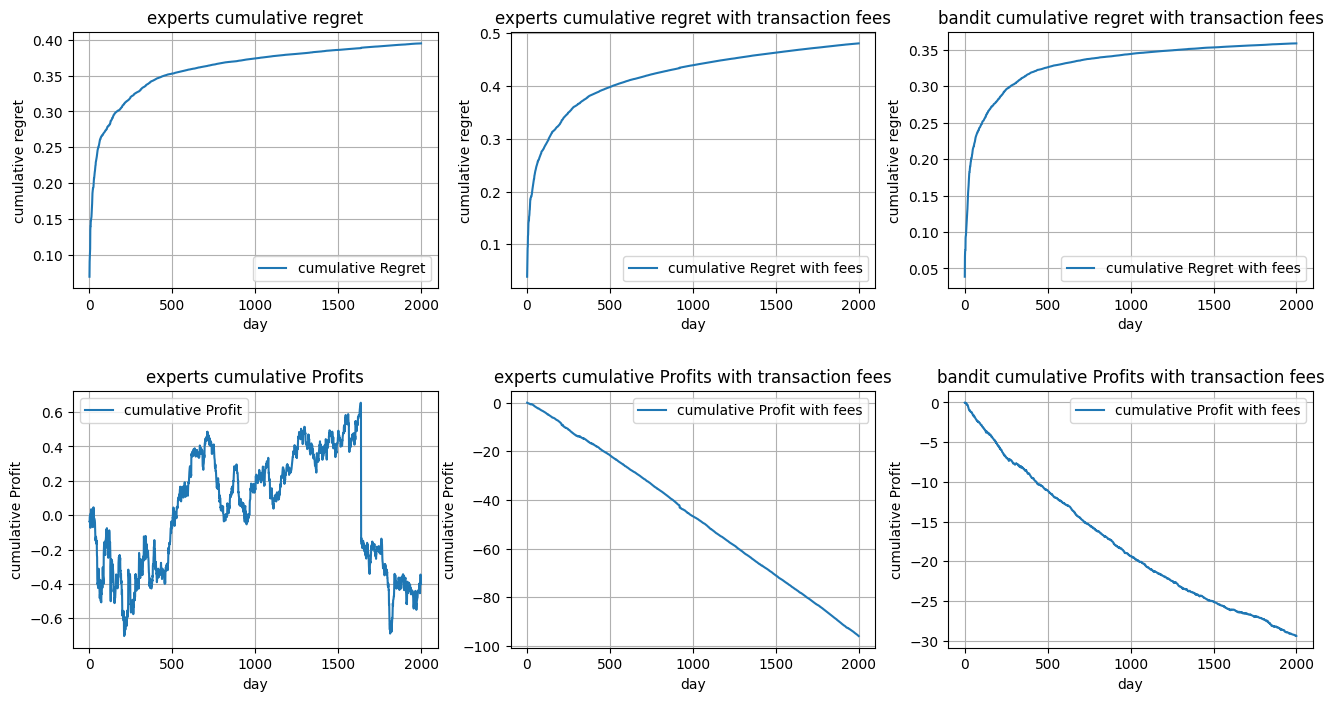

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import re



stock_data :pd.DataFrame = None


# can input different .csv files
# some guard statements, verifying input
# user input, reading the csv file and exception/security checks.
file = "stocks.csv" #if len(sys.argv) < 2 else sys.argv[1]
if not file.endswith('.csv'):
    print('File must be a CSV file.')
    exit()


pattern = re.compile(r'^[\w.\\-]+$')
if not pattern.match(file):
    print('Invalid file name.')
    exit()


try:
    stock_data = pd.read_csv(file, header=None)
except FileNotFoundError as e:
    print('Could not read file.', e)
    exit()
except pd.errors.ParserError as e:
    print('Could not parse file.', e)
    exit()
except pd.errors.EmptyDataError as e:
    print('Empty data error.', e)
    exit()

#print(stock_data)
#print(len(stock_data))


# number of available stocks
K = 10

# transactions fees for each stock
transaction_fees = np.arange(0.5, 5.5, 0.5) / 100

# starting 1 euro each day
#experts
weights = np.ones(K)
weights_feed = np.ones(K)
#bandit
weights_bandit = np.ones(K)


# data to track
day_profits = []
day_profits_feed = []
day_profits_bandit = []

day_regrets = []
day_regrets_feed = []
day_regrets_bandit = []


# total days, HORIZON
T = len(stock_data)


epsilon = 0.9


# each day experiment
for t in range(T):
    
    # get the changes for  day t
    percentage_changes = stock_data.iloc[t].values


    # Task 1 part
    # Experts without fees
    
    # choose a stock according to its weight propability distribution
    # experts stock decision
    chosen_stock = np.random.choice(K, p=weights / np.sum(weights))
    # calc the profit from the stock decision. 
    profit = percentage_changes[chosen_stock] 

    # append profits to the lists
    day_profits.append(profit)

    # calc the regret for each stock
    # the regret is: the best possible profit minus my profit
    regret = np.max(percentage_changes) - profit

    day_regrets.append(regret/(t + 1))
    #day_regrets.append(regret)
    

    # Task 2 part
    # Experts with fees

    # choose a stock according to its weight propability distribution
    # experts stock decision
    chosen_stock_feed = np.random.choice(K, p=weights_feed / np.sum(weights_feed))
    
    # subtract the fee of the according stock
    profit_feed = percentage_changes[chosen_stock_feed] - transaction_fees[chosen_stock_feed]
    
    # append profits to the lists
    day_profits_feed.append(profit_feed)    
    
    # calc the regret for each stock
    # the regret is: the best possible profit minus my profit
    regret_feed = np.max(percentage_changes - transaction_fees) - profit_feed
    
    
    day_regrets_feed.append(regret_feed/(t + 1))
    #day_regrets_feed.append(regret_feed)
    
    
    
    # Task 3 part 
    # Bandits with fees
    
    # bandit stock decision
    chosen_stock_bandit = np.random.choice(K, p=weights_bandit / weights_bandit.sum())
     
    # bandit profit from decision
    profit_bandit = percentage_changes[chosen_stock_bandit] - transaction_fees[chosen_stock_bandit]

    # append profits to the lists
    day_profits_bandit.append(profit_bandit)
    
    # calc the regret for each stock
    # the regret is: the best possible profit minus my profit    
    
    optimal_regret_bandit = np.max(percentage_changes - transaction_fees)
    regret_bandit = optimal_regret_bandit - profit_bandit
    
    day_regrets_bandit.append(regret_bandit/ (t + 1))
    #day_regrets_bandit.append((optimal_profit_bandit - profit_bandit))
    



    
    # update the weights respectively since we know the entire stock changes (full feedback)
    for i, _ in enumerate(percentage_changes):
        
        i_profit = percentage_changes[i]
        i_regret = np.max(percentage_changes) - i_profit
        
        weights[i] *= np.exp(epsilon * -i_regret)
        
        i_profit_feed = percentage_changes[i] - transaction_fees[i]
        i_regret_feed = np.max(percentage_changes) - i_profit_feed
        
        weights_feed[i] *= np.exp(epsilon * -i_regret_feed)
        
    # For the bandit I only update my own decision, since im not in full feedback
    weights_bandit[chosen_stock_bandit] *= np.exp(epsilon * -regret_bandit)

    
    
# calc cumulative data.
cumulative_regret = np.cumsum(day_regrets)
cumulative_regret_feed = np.cumsum(day_regrets_feed)
cumulative_regret_bandit = np.cumsum(day_regrets_bandit)

cumulative_profit = np.cumsum(day_profits)
cumulative_profit_feed = np.cumsum(day_profits_feed)
cumulative_profit_bandit = np.cumsum(day_profits_bandit)


# display results.
fig, axes = plt.subplots(2, 3, figsize=(16,8))

axes[0][0].plot(range(1, T + 1), cumulative_regret, label='cumulative Regret')
axes[0][0].set_xlabel('day')
axes[0][0].set_ylabel('cumulative regret')
axes[0][0].set_title('experts cumulative regret')
axes[0][0].legend()
axes[0][0].grid(True)

axes[0][1].plot(range(1, T + 1), cumulative_regret_feed, label='cumulative Regret with fees')
axes[0][1].set_xlabel('day')
axes[0][1].set_ylabel('cumulative regret')
axes[0][1].set_title('experts cumulative regret with transaction fees')
axes[0][1].legend()
axes[0][1].grid(True)


axes[1][0].plot(range(1, T + 1), cumulative_profit, label='cumulative Profit')
axes[1][0].set_xlabel('day')
axes[1][0].set_ylabel('cumulative Profit')
axes[1][0].set_title('experts cumulative Profits')
axes[1][0].legend()
axes[1][0].grid(True)

axes[1][1].plot(range(1, T + 1), cumulative_profit_feed, label='cumulative Profit with fees')
axes[1][1].set_xlabel('day')
axes[1][1].set_ylabel('cumulative Profit')
axes[1][1].set_title('experts cumulative Profits with transaction fees')
axes[1][1].legend()
axes[1][1].grid(True)

axes[0][2].plot(range(1, T + 1), cumulative_regret_bandit, label='cumulative Regret with fees')
axes[0][2].set_xlabel('day')
axes[0][2].set_ylabel('cumulative regret')
axes[0][2].set_title('bandit cumulative regret with transaction fees')
axes[0][2].legend()
axes[0][2].grid(True)

axes[1][2].plot(range(1, T + 1), cumulative_profit_bandit, label='cumulative Profit with fees')
axes[1][2].set_xlabel('day')
axes[1][2].set_ylabel('cumulative Profit')
axes[1][2].set_title('bandit cumulative Profits with transaction fees')
axes[1][2].legend()
axes[1][2].grid(True)


fig.subplots_adjust(hspace=0.4)  # hspace controls the vertical space

plt.show()


